<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/sqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q 'gwpy==1.0.1'
import numpy as np
import gwpy
from scipy.interpolate import (interp2d, InterpolatedUnivariateSpline)
from pdb import set_trace

In [2]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
print("GW170817 data")
print(ldata)

GW170817 GPS: 1187008882.4
GW170817 data
TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
            1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
           unit: dimensionless,
           t0: 1187008370.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


#### 1 Reference Structure

In [3]:
# Reference Analysis
# https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L2120
# https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/signal/qtransform.py#L86
# https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/signal/qtransform.py#L117
# https://github.com/gwpy/gwpy/blob/26f63684db17104c5d552c30cdf01248b2ec76c9/gwpy/spectrogram/spectrogram.py#L61
# gwpy (v2.0.4) 
#   --> timeseries.py 
#         --> q_transform(L-2120) <-- .frequencyseries.FrequencySeries(L-2259)
#                                       <-- window = asd_kw.pop(window type)(L-2262)  
#                                       <-- fftlength
#                                       <-- recommended_overlap(L-2270) <-- signal.window.py
#                                       <-- asd(L-2271) <-- timeseries.py(L-302)
#                                       <-- instance(frequencyseries)(L-2272)
#                                           <-- whiten(L-1669)
#                                       <-- Segment(L-2283) <-- segments.segments.py(L-37)
#                                 **key <-- .qtransform.q_scan <-- signal.qtransform(L-635) 
#                                                Transform data by scanning over a `QTiling`
#                                               'TimeSeries.q_transform is the wrapper of q_scan'
#                                      **key <-- QTiling(L-685) <-- Class QTailing(L-86)
#                                            return a raw Q-transform and its significance
#                                            ----------------------------------------------------------------------------
#                                            ** Note: QTiling __init__ -->
#                                               qlist = list(self._iter_qs())
#                                                if self.frange[0] == 0:  # set non-zero lower frequency
#                                                    self.frange[0] = 50 * max(qlist) / (2 * pi * self.duration)
#                                                maxf = self.sampling / 2 / (1 + 11**(1/2.) / min(qlist))
#                                                if isinf(self.frange[1]):
#                                                    self.frange[1] = maxf
#                                                elif self.frange[1] > maxf:  # truncate upper frequency to maximum
#                                                    warnings.warn('upper frequency of %.2f is too high for the given '
#                                                                  'Q range, resetting to %.2f'
#                                                                 % (self.frange[1], maxf))
#                                                    self.frange[1] = maxf   
#                                            ----------------------------------------------------------------------------
#
#              --> qgram.interpolate <-- signal.qtransform.py(L-488) <-- qgram class(L-453)
#                          |
#                        ^ | ^
#                          ^
#              --> signal.qtransform.py
#                 -->interpolate(L-488) 'Interpolate this `QGram` over a regularly-gridded spectrogram'
#                                       out : `~gwpy.spectrogram.Spectrogram`
#                                                 output `Spectrogram` of normalised Q energy
#                        --> scipy.interpolate(interp2d, InterpolatedUnivariateSpline)(L-539)
#                            Interpolate this `QGram` over a regularly-gridded spectrogram
#                        --> out = Spectrogram(L-552) <-- spectrogram.spectrogram.py(L-61)
#                                     |
#                                   ^ | ^
#                                     ^
#                                 __new__(cls, data, unit=None, t0=None, dt=None, f0=None, df=None,
#                                  times=None, frequencies=None,
#                                  name=None, channel=None, **kwargs):(L-131)
#                          """Generate a new Spectrogram.
#                          """
#                          generate Spectrogram
#                                        return super().__new__(cls, data, unit=unit, name=name,
#                                                              channel=channel, **kwargs)(L-160)
#                             --> out.q = self.plane.q(L-555)
#
#                         --> rnumerate(self.energies)
#                         --> InterpolatedUnivariateSpline(xrow, row.value)(L-539) <-- Scipy
#                         --> (optional)  interp2d() <-- Scipy
#                         --> geomspace <-- Scipy
#                            --> out.q = self.plane.q(L-588)
#                 --> new <-- interpolcated out


In [4]:
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

Fetched 1 URLs from www.gw-openscience.org for [1187008852 .. 1187008884))
Reading data... [Done]


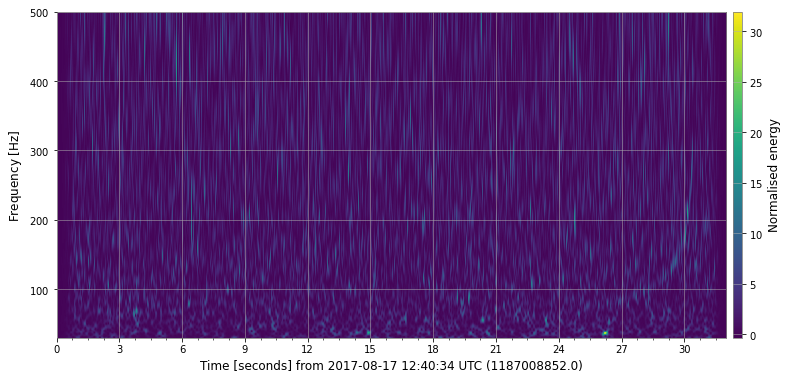

In [5]:

hq = hdata.q_transform(frange=(30, 500))
#default qrange = (4, 64)

plot = hq.plot()
plot.colorbar(label="Normalised energy")

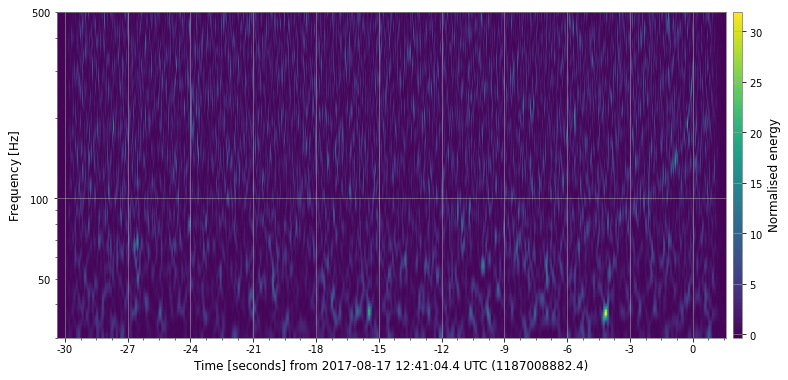

In [6]:
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot

#### Modifications

In [7]:
def spectrogram(self):
        
    frequencies = self.plane.frequencies
    dtype = self.energies[0].dtype
    # build regular Spectrogram from peak-Q data by interpolating each
    # (Q, frequency) `TimeSeries` to have the same time resolution
    
    tres = abs(Segment(outseg)) / 1000.
    xout = np.arange(*outseg, step=tres)
    nx = xout.size
    ny = frequencies.size
    out = Spectrogram(np.empty((nx, ny), dtype=dtype),
                      t0=outseg[0], dt=tres, frequencies=frequencies)
    # record Q in output
    out.q = self.plane.q
    # interpolate rows
    for i, row in enumerate(self.energies):
        xrow = np.arange(row.x0.value, (row.x0 + row.duration).value,
                            row.dx.value)
        interp = InterpolatedUnivariateSpline(xrow, row.value)
        out[:, i] = interp(xout).astype(dtype, casting="same_kind",
                                        copy=False)
    if fres is None:
        return out
    # interpolate the spectrogram to increase its frequency resolution
    # --- this is done because Duncan doesn't like interpolated images
    #     since they don't support log scaling
    interp = interp2d(xout, frequencies, out.value.T, kind='cubic')
    if not logf:
        if fres == "<default>":
            fres = .5
        outfreq = np.arange(
            self.plane.frange[0], self.plane.frange[1], fres,
            dtype=dtype)
    else:
        if fres == "<default>":
            fres = 500
        outfreq = np.geomspace(
            self.plane.frange[0],
            self.plane.frange[1],
            num=int(fres),
        )
    new = type(out)(
        interp(xout, outfreq).T.astype(
            dtype, casting="same_kind", copy=False),
        t0=outseg[0], dt=tres, frequencies=outfreq,
    )
    new.q = self.plane.q
    return new

In [8]:
def q_spectrogram(q_range=[80,100], frange=[30, 500]):
    return 